# Generate a minimal 3D image from a 2D section

In [37]:
## Imports
from sklearn.neighbors import BallTree
import anndata as ad
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

In [133]:
## Load data
fn_2D = "../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_2D/measured_mask_centroids_2D_*.csv"
fn_3D = "../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_3D.csv"

# 2D centroids
files_2D = np.array(glob.glob(fn_2D)) ## unsorted list of files (full path)
data2 = pd.concat([pd.read_csv(file) for file in files_2D])
data2.sort_values(by='z', inplace=True)

# 3D centroids
data3 = pd.read_csv(fn_3D)

In [138]:
def get_stack(
        data2,
        data3, 
        sections: np.ndarray | list,
        sections_sorted: np.ndarray,
        section_idcol: str = 'z',
        cell_idcol: str = 'id', 
        k: int = 39, 
        max_sections: int = 20
) -> dict:
    """
    For each 2D section, find the minimum number of sections that include all 3D neighbors of cells in the 2D section.

    The algorithm constructs a connectivity tree based on 3D locations, then, for all queried original 2D sections, 
    increases the number of sections above and below the original 2D section until all 3D neighbors are included
    and returns the resulting stack (list of section IDs).
    Note: To be considered 'included', a cell must be present in a section, irrespective of mask area.
    Cell IDs must match between data2 and data3.

    Parameters
    ----------
    data2 : pd.DataFrame
        Table 2D cell positions as ['x','y'] and columns cell_idcol, section_idcol
    data3 : pd.DataFrame
        Table 3D cell positions as ['x','y','z'] and column cell_idcol
    sections : np.ndarray | list
        2D section IDs to generate stack for
    sections_sorted : np.ndarray
        All 2D section IDs, sorted by z-axis
    section_idcol : str, optional
        Column name in data2 that contains section IDs, by default 'z'
    cell_idcol : str, optional
        Column name in data2 that contains cell IDs, by default 'id'
    k : int, optional
        Number of 3D nearest neighbors to include per 2D cell, by default 39
    max_sections : int, optional
        How many sections to query in either z-direction, by default 20

    Returns
    -------
    dict | None
        keys = section IDs, values = np.ndarray of section IDs in stack
    """

    cells_per_section = data2.groupby(section_idcol)[cell_idcol].unique()[sections_sorted].values # which cell ids are in which section

    stacks = {}
    for section in sections:
        s_pos = np.where(sections_sorted == section)[0][0] # position of section in sorted list
        
        # Find 3D neighbors of cells in 2D section
        ids2 = data2.loc[ data2[section_idcol] == section, cell_idcol].values # query cells: all cells in 2D section
        coord = data3[['x','y','z']].values
        coord_filter = np.isin( data3[cell_idcol].values, ids2 )
        tree = BallTree(coord, leaf_size= 2) # build connectivity tree
        ind = tree.query(coord[ coord_filter, : ], k=k, return_distance= False) # list of neighbors for every 2D cell, by index of coord
        ids3 = data3.iloc[ np.unique(ind), data3.columns==cell_idcol].values.flatten() # cell ids of 2D cells & neighbors

        stack = [section]
        if s_pos < sections_sorted.size-1:
            # Go up sections until all 3D neighbors above are included
            query_above = ids3[ np.isin(ids3, np.concatenate(cells_per_section[s_pos+1:])) ]
            included = np.zeros_like(query_above, dtype=bool)
            i = 1
            while (i < max_sections) & (s_pos+i < len(sections_sorted)):
                included = included | np.isin(query_above, cells_per_section[s_pos+i])
                stack.append(sections_sorted[s_pos+i])
                if included.all():
                    break
                i += 1

        if section > 0:
            # Same downwards
            query_below = ids3[ np.isin(ids3, np.concatenate(cells_per_section[:section])) ]
            included = np.zeros_like(query_below, dtype=bool)
            i = 1
            while (i < max_sections) & (s_pos-i >= 0):
                included = included | np.isin(query_below, cells_per_section[s_pos-i])
                stack.append(sections_sorted[s_pos-i])
                if included.all():
                    break
                i += 1
        stacks[section] = sections_sorted[ np.isin(sections_sorted, stack) ] # sort

    return stacks

In [139]:
## Get stack for all sections
sections_sorted = np.sort(data2['z'].unique())

stacks = get_stack(
    data2,
    data3,
    sections = data2['z'].unique(),
    sections_sorted = sections_sorted)

# Save (pickle)
fn = "../../data/temp/Kuett_2022_stacks.pkl"
with open(fn, 'wb') as f:
    pickle.dump(stacks, f)

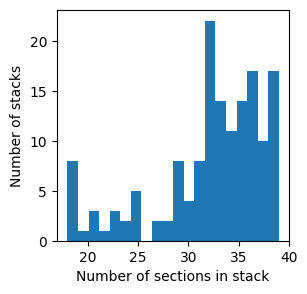

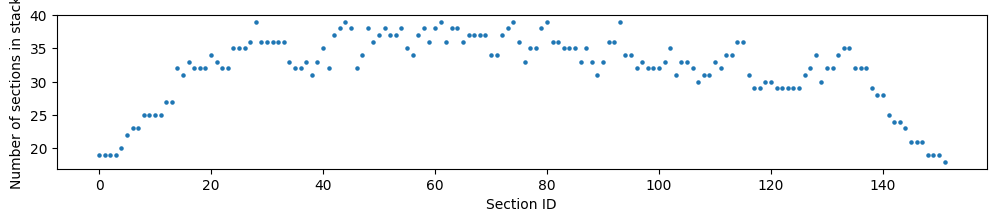

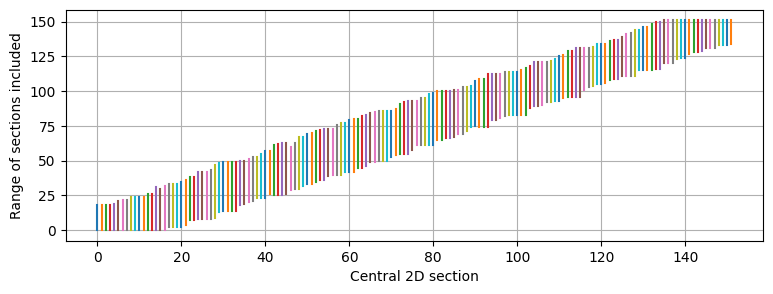

In [120]:
## Assess results
# Distribution of stack lengths
stacksize = [len(stack) for stack in stacks.values()]
plt.figure(figsize=(3,3))
plt.hist(stacksize, bins=20)
plt.xlabel('Number of sections in stack')
plt.ylabel('Number of stacks')
plt.show()

# Get number of sections per stack
plt.figure(figsize=(12, 2))
plt.scatter(np.arange(len(stacksize)), stacksize, s=5)
plt.xlabel('Section ID')
plt.ylabel('Number of sections in stack')
plt.show()

# Range of sections included in each stack
plt.figure(figsize=(9, 3))
for i, section in enumerate(sections_sorted):
    plt.plot((i,i), (stacks[section].min(),stacks[section].max()))
plt.xlabel('Central 2D section')
plt.ylabel('Range of sections included')
plt.grid()
plt.show()

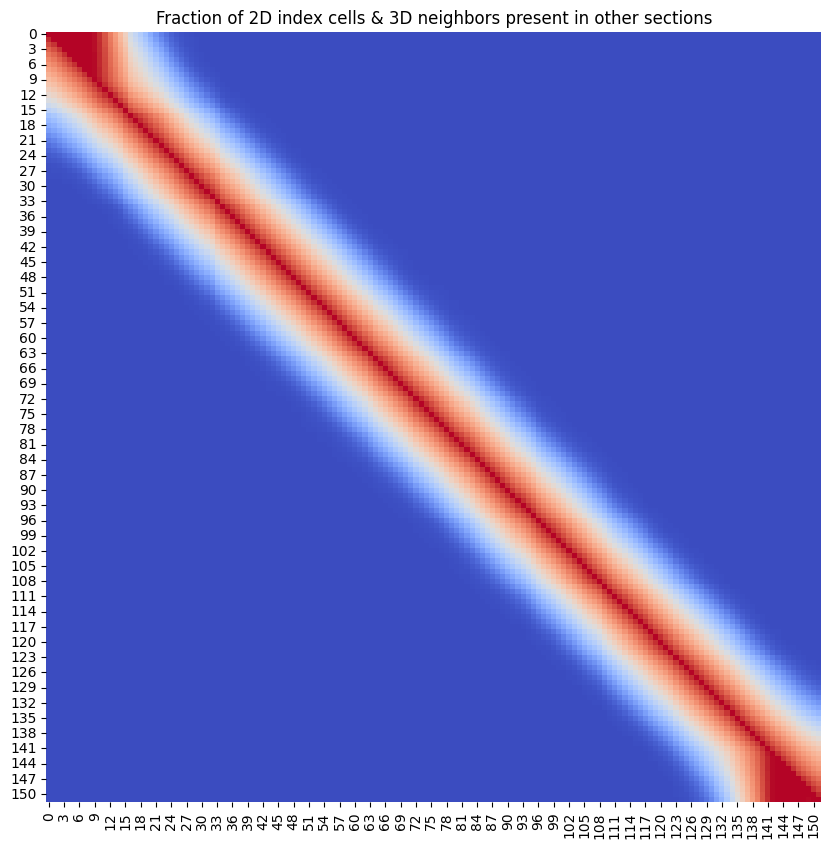

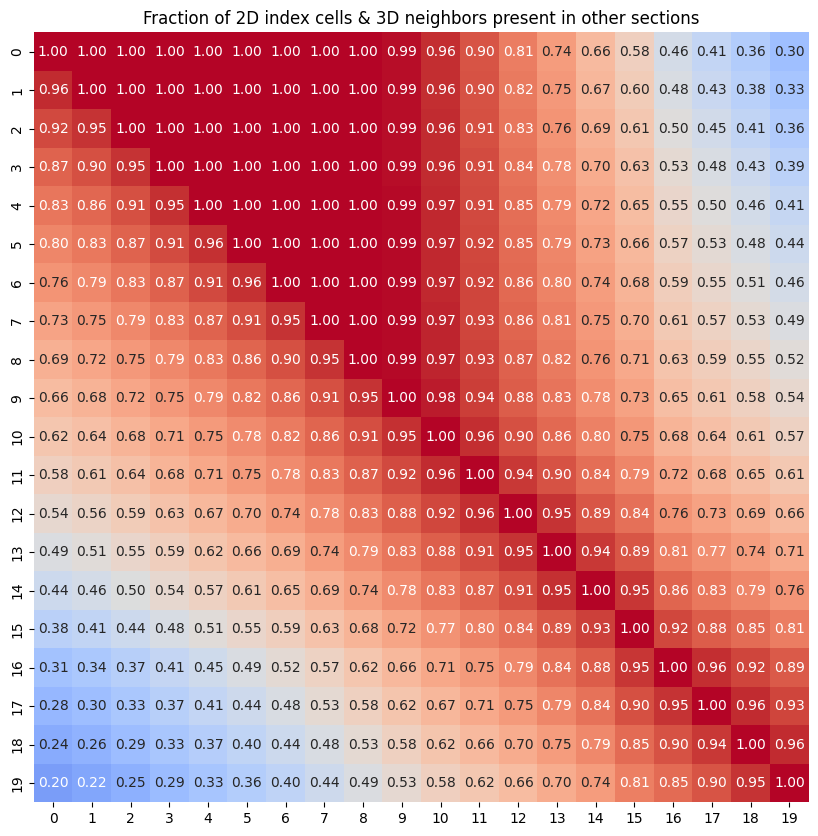

In [ ]:
## Calculate the fraction of all cells (2D cells & their 3D neighbors) that are present in each section

# Find 3D neighbors of cells in 2D section (from get_stack)
sections = data2['z'].unique()
sections_sorted = np.sort(sections)
section_idcol = 'z'
cell_idcol = 'id'
k = 39
cells_per_section = data2.groupby(section_idcol)[cell_idcol].unique()[sections_sorted].values # which cell ids are in which section

ids3_dict = {}
for s, section in enumerate(sections):
    ids2 = data2[ data2[section_idcol] == section ].obs[cell_idcol].values # query cells: all cells in 2D section
    coord_filter = np.isin( data3[cell_idcol].values, ids2 )
    coord = data3[['x','y','z']].values
    tree = BallTree(coord, leaf_size= 2) # build connectivity tree
    ind = tree.query(coord[ coord_filter, : ], k=k, return_distance= False) # list of neighbors for every 2D cell, by index of coord
    ids3 = data3.iloc[ np.unique(ind), data3.columns==cell_idcol].values.flatten() # cell ids of 2D cells & neighbors
    ids3_dict[section] = ids3
n_cells_per_section = [ len(ids3_dict[s]) for s in sections ]

# Calculate fraction of shared cells
n_sections = len(sections_sorted)
corr_mat = np.zeros((n_sections, n_sections), dtype=float)
for i in range(n_sections):
    corr_mat[i, i] = 1
    for j in range(i + 1, n_sections):
        ## Get number of shared cell IDs
        count = np.isin(ids3_dict[i], ids3_dict[j]).sum()
        
        corr_mat[i, j] = count / n_cells_per_section[i] if n_cells_per_section[i] != 0 else 0
        corr_mat[j, i] = count / n_cells_per_section[j] if n_cells_per_section[j] != 0 else 0

fraction_with_neighbors = pd.DataFrame(corr_mat, index=sections_sorted, columns=sections_sorted)

# Plot
plt.figure(figsize=(10,10))
sns.heatmap(fraction_with_neighbors, annot=False,
            cmap='coolwarm', cbar=False, vmin=0)
plt.title('Fraction of 2D index cells & 3D neighbors present in other sections')
plt.show()

# Plot section of interest
plt.figure(figsize=(10,10))
sns.heatmap(fraction_with_neighbors.iloc[:20,:20], annot=True, fmt=".2f", annot_kws={'size':10},
            cmap='coolwarm', cbar=False, vmin=0)
plt.title('Fraction of 2D index cells & 3D neighbors present in other sections')
plt.show()

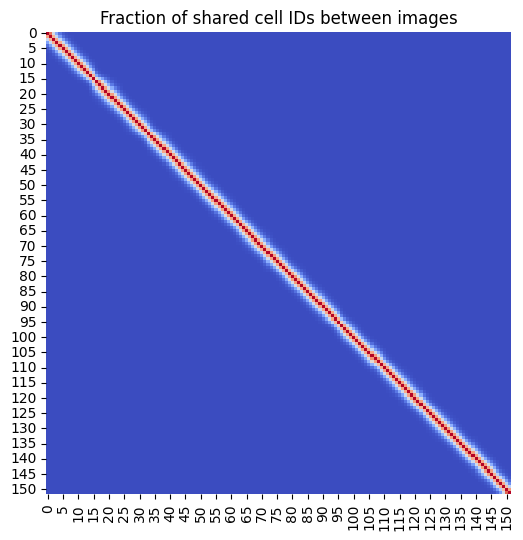

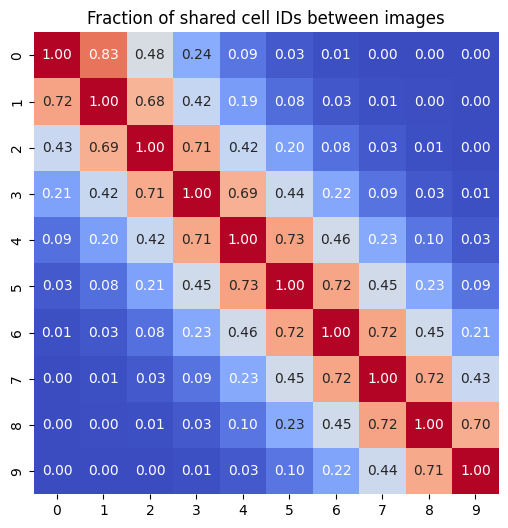

In [129]:
## Calculate the fraction of cell labels that are present in both images (without neighbors)
sections = data2['z'].unique()
cells_per_section = data2.groupby(section_idcol)[cell_idcol].unique()[sections_sorted].values
n_cells_per_section = [ len(cells) for cells in cells_per_section ]
n_sections = len(sections)

corr_mat = np.zeros((n_sections, n_sections), dtype=float)
for i in range(n_sections):
    corr_mat[i, i] = 1
    for j in range(i + 1, n_sections):
        ## Get number of shared cell IDs
        count = np.isin(cells_per_section[i], cells_per_section[j]).sum()
        
        corr_mat[i, j] = count / n_cells_per_section[i] if n_cells_per_section[i] != 0 else 0
        corr_mat[j, i] = count / n_cells_per_section[j] if n_cells_per_section[j] != 0 else 0

fraction = pd.DataFrame(corr_mat, index=sections_sorted, columns=sections_sorted)

# Plot entire matrix
plt.figure(figsize=(6,6))
sns.heatmap(fraction, annot=False, cmap='coolwarm', cbar=False)
plt.title('Fraction of shared cell IDs between images')
plt.show()

# Plot section of interest
plt.figure(figsize=(6,6))
sns.heatmap(fraction.iloc[:10,:10], annot=True, fmt=".2f", cmap='coolwarm', cbar=False)
plt.title('Fraction of shared cell IDs between images')
plt.show()